In [1]:
import nltk
import sys
import os
from lxml import etree
import datetime
import numpy as np
from parser import * 

In [4]:
trainPath = "trainingData/train"
testPath = "trainingData/test"
features = ['text','meanTimeGapBetweenWritings','meanLengthOfWritings']
nbChunks = 10 

In [7]:
trainSubjects = parsing (trainPath, features,nbChunks)
trainLabels = labelingTrain(trainPath)
testSubjects = parsing (testPath, features,nbChunks)
testLabels = labelingTest(testPath)

In [9]:
def PrintData(data,nb_subjects):
    # la fonction affiche nb_subjects du dictinnaire
    cpt=0
    for idsubject in data.keys():
        if cpt < nb_subjects :
            print("id_subject=  ",  idsubject)
            for numchunk in range(1,nbChunks+1):
                print ("\nchunk",numchunk, " =>")
                for t in range(len(data[idsubject][numchunk]['text'])):
                    print("writing ", t , "=>\n")
                    print(data[idsubject][numchunk]['text'], "\n")
        print("\n")
        cpt += 1
            
#PrintData(trainSubjects,1)    

In [10]:
import gensim
from gensim import corpora,models, similarities
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

In [23]:
def DictConcatenate(d):
    a = ""
    for key in d.keys():
        a +=d[key]
    return a


def extractingTextsAll(trainSubjects, trainLabels ,tokens_only=False ):
    # cette fonction retourne tous les writings de chaque utilisateur 
   
    for k in trainSubjects.keys() :
        for j in range (1,11):
            for t in (trainSubjects[k][j]['text']).keys():
                # si tokens_only alors c'est les données test
                if tokens_only:
                    Ytest.append(trainLabels[k])
                    yield gensim.utils.simple_preprocess(trainSubjects[k][j]['text'][t])
                else:
                    # les données sont celle de  training data et on ajoute les tags
                    yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(trainSubjects[k][j]['text'][t]), [trainLabels[k]])
            
#pour gensim
def extractingNchuncks(trainSubjects, trainLabels ,chunck):
    # cette fonction retourne tous les writings de chaque utilisateur 
   
    for k in trainSubjects.keys() :
        for j in range (1,chunck+1):
            # les données sont celle de  training data et on ajoute les tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(DictConcatenate(trainSubjects[k][j]['text'])), [trainLabels[k]])

In [24]:
def F1(Y , Yhat):
    totalMatGs = np.zeros((2,2))
    totalMatGs = totalMatGs + confusion_matrix(Y , Yhat)
    print(confusion_matrix(Y , Yhat))
    precision , recall = getEvalResults(totalMatGs)
    print("  Precison = ",round(precision,2))
    print("  Recall = ",round(recall,2))
    print("f1_score calculé = ", ( 2 * (precision * recall)/(precision + recall) ))
    print("f1_score  = ", f1_score(Y , Yhat, average='micro'))

In [12]:
Xtrain = list(extractingTextsAll(trainSubjects, trainLabels))
train , Ytrain = list(x[0] for x in Xtrain),list(x[1][0] for x in Xtrain)
X = list(extractingTextsAll(testSubjects, testLabels))
Xtest,Ytest = list(x[0] for x in X),list(x[1][0] for x in X)

In [25]:
def GensimMethode(Xtrain , epochs):
    
    model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=epochs)
    model.build_vocab(Xtrain)
    model.train(Xtrain, total_examples=model.corpus_count, epochs=model.epochs)
    return model


In [26]:
model = GensimMethode(Xtrain , 20)

In [36]:
#ces fonctions retournent les representation gensim des writings sous forme d'une matrice
def ExtractVectorstrain( model, Xtrain, Ytrain):
    
    label_encoder = LabelEncoder()
    label_encoder.fit(Ytrain)
    label_train = label_encoder.transform(Ytrain)

    trainSub = []
    for doc_id in range(len(Xtrain)):
        trainSub.append(model.infer_vector(Xtrain[doc_id]))
    trainSub = np.array(trainSub)  
    return trainSub ,    label_train
def ExtractVectorstest(Xtest, Ytest):
    label_t = LabelEncoder()
    label_t.fit(Ytrain)
    label_test = label_t.transform(Ytest)

    testSub = []
    for doc_id in range(len(Xtest)):
        testSub.append(model.infer_vector(Xtest[doc_id]))
    testSub = np.array(testSub)
    return testSub,    label_test

In [ ]:
trainSub = []
for doc_id in range(len(Ytrain)):
    trainSub.append(model.infer_vector(train[doc_id]))
trainSub = np.array(trainSub)

In [ ]:
testSub = []
for doc_id in range(len(Ytest)):
    testSub.append(model.infer_vector(Xtest[doc_id]))
testSub = np.array(testSub)

In [ ]:
label_encoder = LabelEncoder()

label_encoder.fit(Ytrain)
label_train = label_encoder.transform(Ytrain)
label_train

In [ ]:
label_t = LabelEncoder()

label_t.fit(Ytrain)
label_test = label_t.transform(Ytest)
label_test

In [ ]:
def modelTest(SubjectsTrain,SubjectsTest,SubjectsLabels):   
    # cette fonction retourne le score de classification et le vecteur predit en utilisant just la fonction similarity de gensim
    score=0
    PredictedLabels = []
    for doc_id in range(len(SubjectsTest)):
        inferred_vector = model.infer_vector(SubjectsTest[doc_id])
        sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
        #Affichage du contenue du writing et les similarities avec les writing du train
        
        # Compare and print the most/median/least similar documents from the train corpus
        #print('Test Document ({}): «{}»\n'.format(doc_id, ' '.join(SubjectsTest[doc_id])))
        #print('Real label   ', SubjectsLabels[doc_id])
        #print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
        i=0
        for label, index in [('MOST', 0), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
            
            if  i==0 :
                PredictedLabels.append(sims[index][0])
                if sims[index][0]==SubjectsLabels[doc_id]:
                    score +=1
            i += 1
            #print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(SubjectsTrain[sims[index][0]].words)))
    return score , np.array(PredictedLabels)

In [ ]:
# test pour chaque  writing
score, PredictedLabels = modelTest(Xtrain,Xtest,Ytest)
print(score/len(Xtest))

In [ ]:
print("Gensim N writings User Resultat")
F1(Ytest, PredictedLabels )

In [ ]:
def classificationSubjectsGensim(testSubjects, testLabels,PredictedLabels):
    #parametres
    #subjectslabels  c'est vraix labels 
    #predictedLabels c'est les labels predit
    #SubjectsTest    l'ensemble de test recuperer dès le debut
    score = 0
    start = 0
    pred_resultat = []
    test_LabelRes = []
    for k in testSubjects.keys() :
        #print("\n", k)
        subjectNbWriting = 0
        for j in range (1,11):
               subjectNbWriting += len(testSubjects[k][j]['text'])
                
        #on recupere les predictions de tous les writings de l'utilisateur
        vecteurPredict = PredictedLabels[start:start+subjectNbWriting]
        #print(vecteurPredict)
        pZero = np.count_nonzero(vecteurPredict == 0)
        pOne  = np.count_nonzero(vecteurPredict == 1)
        predLabel = (0 if pZero > pOne else 1)
        pred_resultat.append(predLabel)
        test_LabelRes.append(testLabels[k])
        #print(pZero, " ",pOne, " ",predLabel)

        if predLabel == testLabels[k] : 
               score +=1
                
        # on recalcule pour chaque utilisateur le debut de son vecteur predit
        start += subjectNbWriting
        
    return score/len(testLabels) , pred_resultat , test_LabelRes
        

In [ ]:
score_comb, pred_resultat , test_LabelRes = classificationSubjectsGensim(testSubjects, testLabels,PredictedLabels)
print(score_comb)

In [ ]:
print("Gensim User Resultat i,e: on prend la classe majoritaire de chaque vecteur d'un user")
F1(test_LabelRes, pred_resultat )


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
y1 = [i if i==1 else -1 for i in Ytest]
y2 = [i if i==1 else -1 for i in PredictedLabels]
precision, recall, _ = precision_recall_curve(y1,y2)
print("  Precison = ",precision)
print("  Recall = ",recall)
average_precision = average_precision_score(y1,y2)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

In [ ]:
#### Nouvelle méthode avec logistic regression

In [ ]:
def TestMethod(meth, Xtrain, Xtest, Ytrain, Ytest):
    meth.fit(Xtrain,Ytrain)
    Ypred = meth.predict(Xtest)
    score = meth.score(Xtest ,Ytest)
    print("score = " ,score)
    F1(Ytest , Ypred)
    return  score, Ypred





def TestApp2(meth , trainSubjects, trainLabels  ,Xtest , Ytest):
    Xtrain ,Ytrain = extractingNchuncks(trainSubjects, trainLabels )
    

In [ ]:
# Word2Vec features only logistic regression
lr1 = LogisticRegression()
TestMethod(lr1, trainSub , testSub, label_train, label_test)


In [ ]:
YpredGensim = lr1.predict(testSub)

In [ ]:
print(lr1.score(testSub, label_test))

In [ ]:
print("Gensim User Resultat i,e: on prend la classe majoritaire de chaque vecteur d'un user")
F1(label_test, YpredGensim )


In [ ]:
s, pred_resultat1 , test_LabelRes1 = classificationSubjectsGensim(testSubjects, testLabels,YpredGensim)
print(s)

In [ ]:
print("Gensim User Resultat i,e: on prend la classe majoritaire de chaque vecteur d'un user")
F1(test_LabelRes1, pred_resultat1 )

Random forest

In [ ]:
Rfc = RandomForestClassifier(n_estimators=50)
sRcf, YpredRfc = TestMethod(Rfc, trainSub , testSub, label_train, label_test)


In [ ]:
sRfc, pred_resultatRfc , test_LabelResRfc = classificationSubjectsGensim(testSubjects, testLabels,YpredGensim)


In [ ]:
F1(pred_resultatRfc , test_LabelResRfc)

In [35]:
def ExtractVectorstest(Xtest):
    testSub = []
    for doc_id in range(len(Xtest)):
        testSub.append(model.infer_vector(Xtest[doc_id]))
    testSub = np.array(testSub)
    return testSub
def extractTest(testSubjects ):
    for t in testSubjects.keys():
        yield gensim.utils.simple_preprocess(testSubjects[t])
                



ERDE

In [ ]:
from  math import *
def lc(o , k):
    return 1 - (1/(1 + exp(k-o)))


In [ ]:
import matplotlib.pyplot as plt

print("lc5")
plt.style.context(('dark_background'))
plt.plot([k for k in range(200) ], [lc(5 , k) for k in range(200)], linestyle='--')
plt.show()
print("lc50")
plt.plot([k for k in range(200) ], [lc(50 , k) for k in range(200)],  linestyle='--')
plt.show()

In [ ]:
cfp = 0.1296           # d=positive AND ground truth=negative (FP)
cfn = 1               # d=negative AND ground truth=positive (FN)
ctp = 1

In [ ]:
def ERDE(o, k, d , t) :
    if  d== 1 and t==1:
        return ctp * lc(o,k)
    if  d== 1 and t==0:
        return cfp
    if  d== 0 and t==1:
        return cfn
    if  d== 0 and t==0:
        return 0

In [ ]:

def computingERDE(meth , testSubjects , o, seuil = 0.6 ):
    res = 0 
    for user ,j in zip (testSubjects.keys()  , [i for i in range(len(testSubjects))]):
        arret = False
        k=0
        for numChunk in range(1,11):
            testS = ExtractVectorstest(list(extractTest(testSubjects[user][numChunk]['text'])))
            for i in range(len(testS)):
                
                a = meth.predict_proba([testS[i]])
                Ypred = -10   #pas de décision
                if a[0][0] >= seuil : 
                    Ypred = 0
                if a[0][1] >= seuil : 
                    Ypred = 1
                if (numChunk == 10 and i == (len(testS) - 1)):
                    Ypred = 0 if a[0][0] > a[0][1] else 1
                # si on a pris une décision alors on calcule le ERDE
                if Ypred != -10:
                    arret = True
                    res += ERDE(o, k+1, Ypred ,testLabels[user] )
                    break
                k += 1
            if arret :
                break
    return res/ len(testSubjects)


In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(trainSub,label_train)
ERDE5= computingERDE(neigh , testSubjects , 5 , 0.9)
ERDE50= computingERDE(neigh , testSubjects , 50 , 0.7)
print(ERDE5)
print(ERDE50)

In [ ]:
lr = LogisticRegression()
lr.fit(trainSub,label_train)
ERDE5= computingERDE(lr , testSubjects , 5 , 0.9)
ERDE5

In [ ]:
ERDE50= computingERDE(lr , testSubjects , 50 , 0.7)
ERDE50

In [ ]:
ERDE50= computingERDE(lr , testSubjects , 50)
ERDE50

In [ ]:
ERDE50= computingERDE(lr , testSubjects , 50 , 0.5)
ERDE50

In [ ]:
Rfc = RandomForestClassifier(n_estimators=50)
Rfc.fit(trainSub,label_train)
ERDE5_Rfc = computingERDE(Rfc , testSubjects , 5 , 0.8)


In [ ]:
ERDE5_Rfc

In [ ]:
ERDE50_Rfc = computingERDE(Rfc , testSubjects , 50 , 0.8)
ERDE50_Rfc

In [ ]:
ERDE50_Rfc = computingERDE(Rfc , testSubjects , 50 , 0.6)
ERDE50_Rfc

In [ ]:
#get_model(trainSubjects , trainLabels)

# Serie temporelle

In [28]:
#train data
Data2App = list(extractingNchuncks(trainSubjects, trainLabels ,10))
Xtrain2App , Ytrain2App = list(x[0] for x in Data2App),list(x[1][0] for x in Data2App)

In [29]:
#test data
Datatest2App = list(extractingNchuncks(testSubjects, testLabels ,10 ))
Xtest2App , Ytest2App = list(x[0] for x in Datatest2App),list(x[1][0] for x in Datatest2App)

In [30]:
model = GensimMethode(Data2App , 20)

In [31]:
XtrainApp , YtrainApp = ExtractVectorstrain(model, Xtrain2App , Ytrain2App)
# à suivre avec ça

In [ ]:
XtrainApp

In [38]:
XtestApp , YtestApp = ExtractVectorstrain( model, Xtest2App , Ytest2App)

In [33]:
#deux chuncks
GensimMethode(Data2App , 20)
lrG = LogisticRegression()
lrG.fit(XtrainApp , YtrainApp)

    

/home/nora/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
testDic = {}
for key in range(0, len(XtestApp) , 10):
    testDic[key] = lrG.predict_proba(XtestApp[key : key+10])

In [40]:
testDic[1450]

array([[0.04790292, 0.95209708],
       [0.44967716, 0.55032284],
       [0.86318747, 0.13681253],
       [0.16846763, 0.83153237],
       [0.70404163, 0.29595837],
       [0.42924468, 0.57075532],
       [0.80039365, 0.19960635],
       [0.64941857, 0.35058143],
       [0.86403518, 0.13596482],
       [0.76467204, 0.23532796]])

In [41]:
prpos = np.array([ p[0] for p in testDic[1450]])
prneg = np.array([ p[1] for p in testDic[1450]])


In [42]:
from statsmodels.tsa.ar_model import AR
model_ar = AR(prneg)
model_ar_fit = model_ar.fit()
model_ar_fit.predict(start = 10 , end=20)

array([0.18104838, 0.20046777, 0.15657071, 0.15859507, 0.13906372,
       0.13197157, 0.12956737, 0.1282626 , 0.12386426, 0.11984482,
       0.11815464])

In [43]:
model_ar = AR(prpos)
model_ar_fit = model_ar.fit()
model_ar_fit.predict(start = 10 , end=20)

array([0.87721063, 0.87392448, 0.96891683, 0.98592556, 1.05271282,
       1.07670114, 1.12444763, 1.157871  , 1.20538787, 1.24169373,
       1.28345869])

In [44]:
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt


In [45]:
def Arima(prpos,prneg, y,n):
    model_arima = ARIMA(prpos[:n], order=(1,2,0))
    model_arima_fit = model_arima.fit()
    predP = model_arima_fit.forecast(steps = (10-n) )[0]
    
    model_arimaN = ARIMA(prneg[:n], order=(1,2,0))
    model_arima_fitN = model_arimaN.fit()
    predN = model_arima_fitN.forecast(steps = (10-n) )[0]
    
    x = [ i for i in range(1,11)]
    yP = list(prpos[:n])+list(predP)
    yN = list(prneg[:n])+list(predN)
    plt.plot(x, yP,label='negative') # anorexique
    plt.plot(x, yN,'-r', label='positive') #non anorexique
    plt.legend(loc='upper right')
    if y==1:
        plt.title('ARIMA applied to an anorexic user in chunk '+str(n))
    else:
        plt.title('ARIMA applied to a non anorexic user in chunk '+str(n))

    plt.show()

/home/nora/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/nora/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/nora/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inte

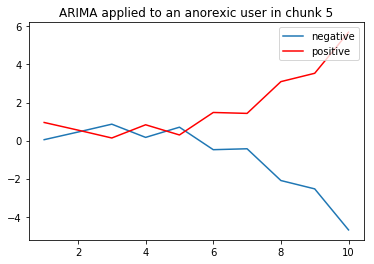

In [51]:
Arima(prpos,prneg,1,5)

In [47]:
prpos1 = np.array([ p[0] for p in testDic[0]])
prneg1 = np.array([ p[1] for p in testDic[0]])
prneg1

array([5.54417719e-04, 3.20803466e-07, 3.97687504e-02, 1.62071702e-09,
       2.18862175e-06, 1.54372043e-03, 7.25857329e-04, 5.23306696e-11,
       5.04754502e-04, 7.63158571e-07])

/home/nora/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


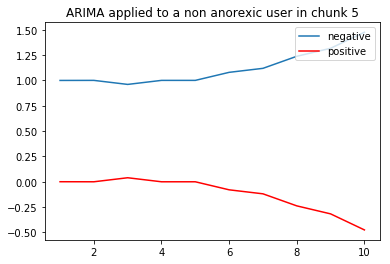

In [48]:
Arima(prpos1, prneg1,0,5)

In [49]:
prbPos = np.array([ p[0] for p in lrG.predict_proba(XtestApp)])
prbNeg =  np.array([ p[1] for p in lrG.predict_proba(XtestApp)])

In [50]:
def ExtractPosNeg( Xtrain, Ytrain):
    
    label_encoder = LabelEncoder()
    label_encoder.fit(Ytrain)
    label_train = label_encoder.transform(Ytrain)

    trainSubPos = []
    trainSubNeg = []
    for doc_id in range(len(Xtrain)):
        if  Ytrain[doc_id] == 1 :
            trainSubPos.append(model.infer_vector(Xtrain[doc_id]))
        else:
            trainSubNeg.append(model.infer_vector(Xtrain[doc_id]))
    trainSubPos = np.array(trainSubPos)  
    trainSubNeg = np.array(trainSubNeg)  

    return trainSubPos ,  trainSubNeg,  label_train

In [ ]:
XtrainAppPos, XtrainAppNeg , YtrainApp = ExtractPosNeg( Xtrain2App , Ytrain2App)
XtestAppPos, XtestAppNeg , YtestApp = ExtractPosNeg( Xtest2App , Ytest2App)

In [ ]:
from os import listdir
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [ ]:
modelS = Sequential()

In [ ]:
#trainSub , testSub, label_train, label_test
seq_len = len(XtrainApp)

In [ ]:
modelS.add(LSTM(XtrainApp.shape[0], input_shape=(1,XtrainApp.shape[1])))
modelS.add(Dense(1, activation='sigmoid'))

In [ ]:
modelS.summary()

In [ ]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)


In [ ]:
modelS.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


In [ ]:

X_train = np.reshape(XtrainApp, (XtrainApp.shape[1], 1, XtrainApp.shape[0])).transpose()


In [ ]:
Y_train = np.reshape(YtrainApp, (len(YtrainApp),1))

In [ ]:
modelS.fit(X_train, YtrainApp, epochs=200,  callbacks=[chk])

In [ ]:
def reshape_LSTM(X,Y):
    X_t = np.reshape(X, (X.shape[1], 1, X.shape[0])).transpose()
    Y_t = np.reshape(Y, (len(Y),1))
    return X_t , Y_t

In [ ]:
X_test , Y_test = reshape_LSTM(XtestApp,YtestApp)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
#loading the model and checking accuracy on the test data

test_preds = modelS.predict_classes(X_test)
print(" le score est : ",accuracy_score(Y_test, test_preds))


In [ ]:
F1(test_preds, Y_test)